In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr

/home/remedios/kaisr/kaisr


In [3]:
import nibabel as nib
import numpy as np
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import torch

from utils.plot import *
from tqdm import tqdm

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
set_display_mode(mode='dark')

In [6]:
DTYPE = np.float32

In [7]:
fpath = Path("../../data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled.nii")

In [8]:
vol = nib.load(fpath).get_fdata(dtype=DTYPE)

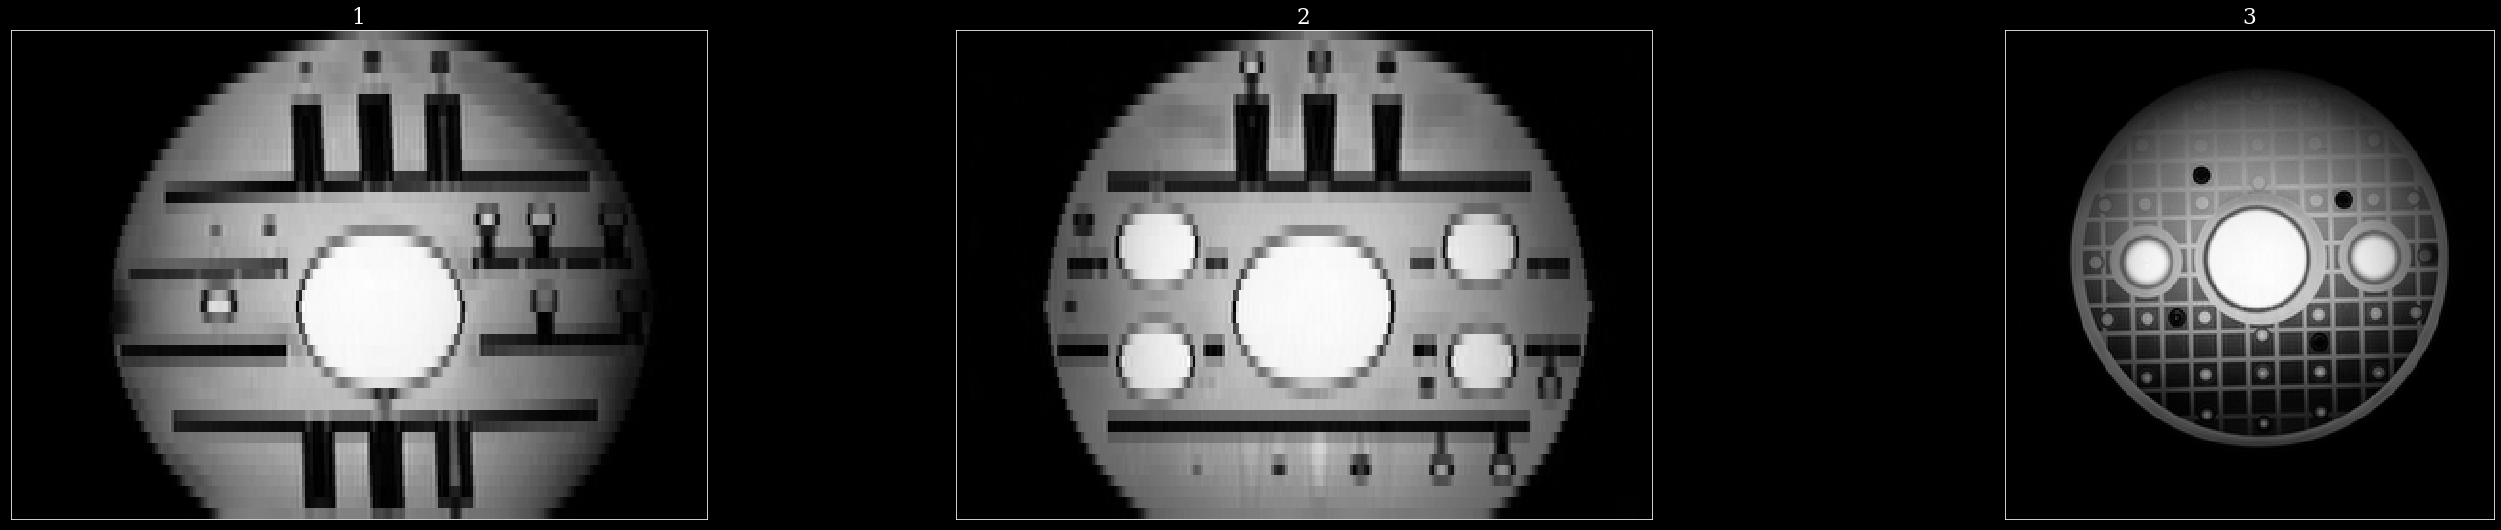

In [9]:
center_vol_plot(vol, target_shape=(256, 256, 180))

In [11]:
from utils.train_loader_slices import TrainSet
from torch.utils.data import DataLoader

In [12]:
batch_size = vol.shape[-1]
n_iters = 5000

In [13]:
ds = TrainSet(
    img_fpath=fpath,
    n_iters=n_iters,
    slice_axis=2,
)

data_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True, 
    pin_memory=True,
    num_workers=4,
)

In [14]:
device = torch.device(f'cuda:0')

In [15]:
x = ds.get_all_slices_as_tensor().to(device)

In [16]:
from models.iwae import IWAE
from models.vanilla_vae import VanillaVAE as VAE

In [17]:
z_dim = 256
in_channels = 1

In [18]:
model = IWAE(
    in_channels=in_channels, 
    latent_dim=z_dim,
    num_samples=5,
    hidden_dims=[64, 128, 256, 512, 1024],
).to(device)

In [19]:
lr = 1e-4
opt = torch.optim.Adam(model.parameters(), lr=lr)
opt.zero_grad()
opt.step()

In [21]:
N_STEPS = n_iters
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt,
    max_lr=lr,
    total_steps=N_STEPS+1,
    cycle_momentum=True,
)

In [22]:
with tqdm(total=n_iters) as pbar:    
    pbar_dict = {
        'loss': np.finfo(np.float32).max,
        'Reconstruction_Loss': np.finfo(np.float32).max,
        'KLD': np.finfo(np.float32).max,
    }
    
    for cur_step in range(n_iters):
        opt.zero_grad()

#         x = imgs.to(device)
        loss_dict = model.loss_function(*model(x), M_N=batch_size / len(data_loader))
        loss = loss_dict['loss']
        recon_loss = loss_dict['Reconstruction_Loss']
        kld_loss = loss_dict['KLD']

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        scheduler.step()

        pbar_dict = loss_dict

        pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
        pbar.update(batch_size)

  0%|                                                                                                                              | 0/5000 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (45x65536 and 4096x256)

In [20]:
# IWAE results may require better KLD balancing or differeng K amounts

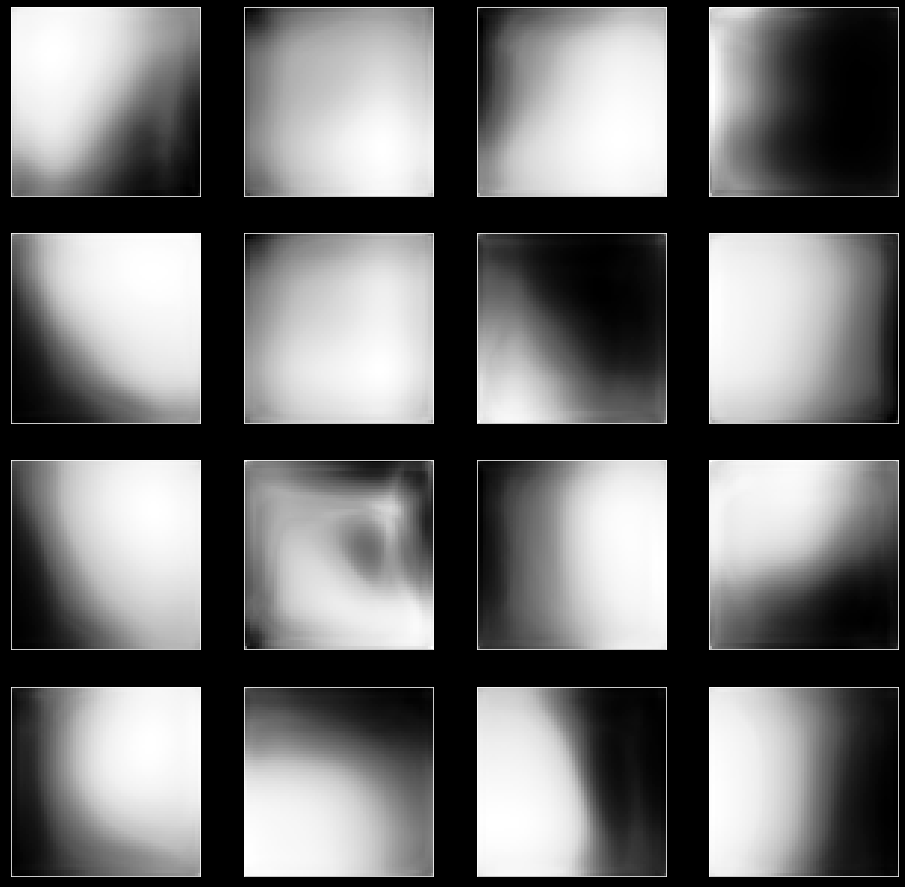

In [25]:
# visualize 16 samples
samples = model.sample(16, current_device=device).detach().cpu().numpy().squeeze()

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, ax in enumerate(axs.flat):
    ax.imshow(samples.squeeze()[i])
    ax.set_xticks([])
    ax.set_yticks([])

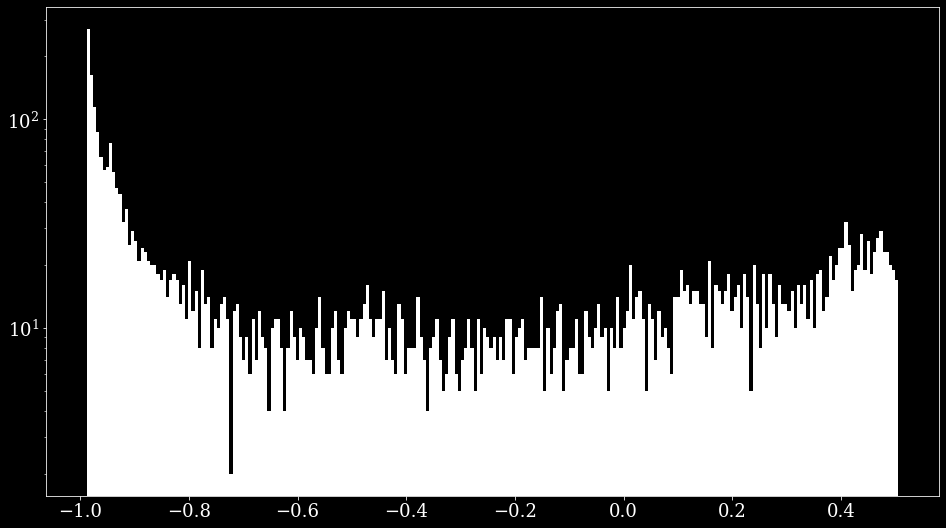

In [22]:
plt.hist(samples[0].flatten(), bins=256)
plt.yscale("log")
plt.show()

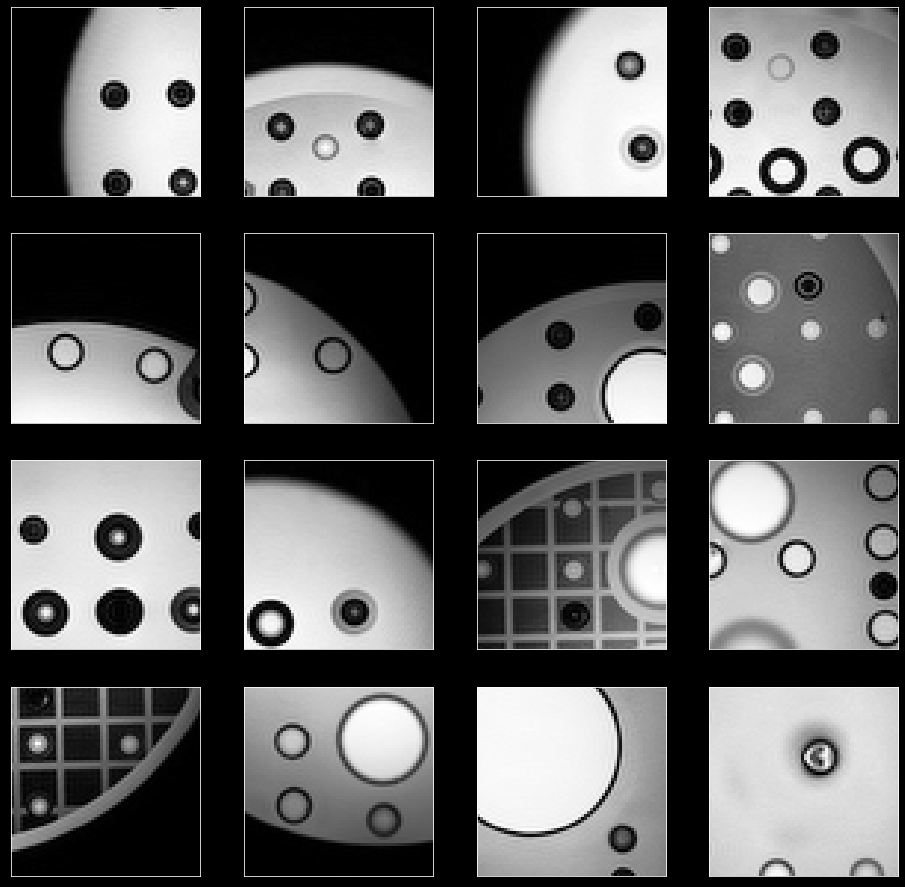

In [23]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

real_batch = [ds.__getitem__(i) for i in range(16)]
for i, ax in enumerate(axs.flat):
    ax.imshow(real_batch[i].squeeze())
    ax.set_xticks([])
    ax.set_yticks([])

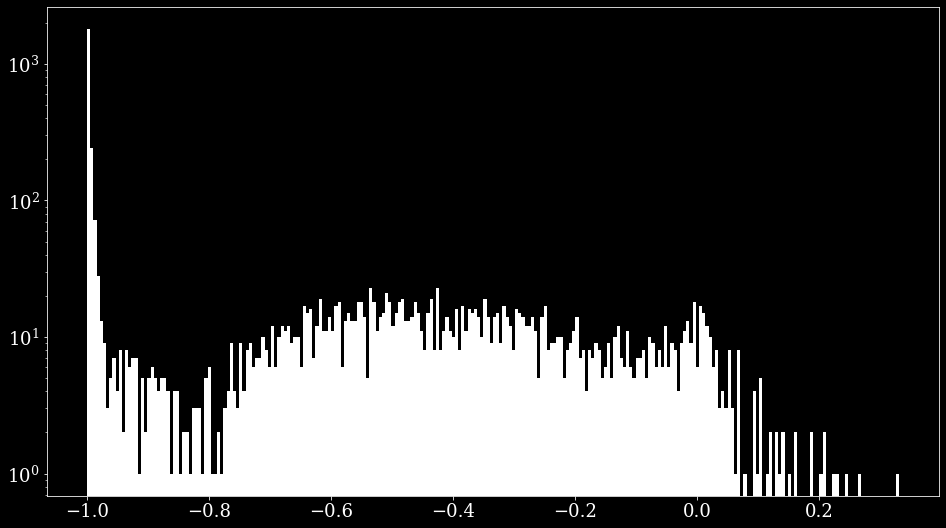

In [24]:
plt.hist(real_batch[5].flatten(), bins=256)
plt.yscale("log")
plt.show()